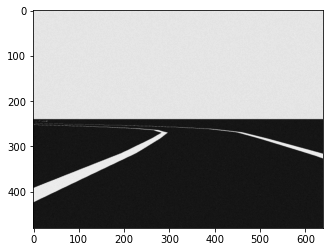

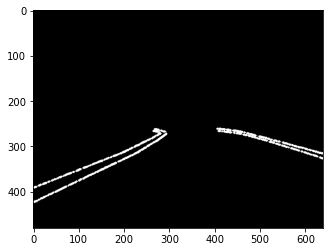

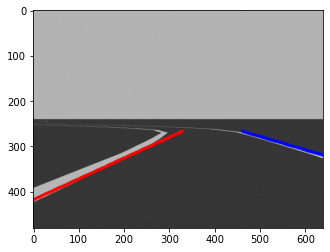

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import math

def draw_lines(img, lines, color=255, thickness=3):
    # If there are no lines to draw, exit.
    if lines is None:
        return
    # Make a copy of the original image.
    img = np.copy(img)
    # Create a blank image that matches the original in size.
    line_img = np.zeros(
        (
            img.shape[0],
            img.shape[1],
        ),
        dtype=np.uint8,
    )
    # Loop over all lines and draw them on the blank image.
    for line in lines:
        for x1, y1, x2, y2 in line:
            cv2.line(line_img, (x1, y1), (x2, y2), color, thickness)
    # Merge the image with the lines onto the original.
    img = cv2.addWeighted(img, 0.8, line_img, 1.0, 0.0)
    # Return the modified image.
    return img

#Read in image
og_image = cv2.imread('test3.png', 0) #Straight
#og_image = cv2.imread('test2.png', 0) #Curved right
#og_image = cv2.imread('test3.png', 0) #Curved left





'''
#Extract dimensions and create the ROI corners before cropping image to remove horizon line
height = og_image.shape[0]
width = og_image.shape[1]
#Calculating Points for Birds-Eye Transform
imgTl = [0,0]
imgTr = [width,0]
imgBr = [width,height]
imgBl = [0,height]
img_params = np.float32([imgTl,imgTr,imgBr,imgBl])


tl = [0,height/1.8]
bl = [0, height/1.2]
tr = [width, height/1.8]
br = [width, height/1.2]
corner_points_array = np.float32([tl,tr,br,bl])

#Calculating transformation matrix and applying it to original image
matrix = cv2.getPerspectiveTransform(corner_points_array,img_params)
og_image = cv2.warpPerspective(og_image,matrix,(width,height))
'''



#Calculate thresholds and apply to Canny Edge Detection
image = cv2.blur(og_image,(5,5))
lower = int(max(0,0.7*np.median(image)))
upper = int(min(255,1.3*np.median(image)))
image = cv2.Canny(image, lower, upper)

#kernel = np.ones((3,3),np.uint8)
#image = cv2.dilate(image,kernel,iterations = 2)

#Calculate Hough Transform to generate lines for each lane
lines = cv2.HoughLinesP(
    image,
    rho=10,
    theta=np.pi / 60,
    threshold=10,
    lines=np.array([]),
    minLineLength=0,
    maxLineGap=0
)


#Group lines into left and right and rmove any flat ones
left_line_x = []
left_line_y = []
right_line_x = []
right_line_y = []
for line in lines:
    for x1, y1, x2, y2 in line:
        if (x2 - x1) != 0:
            slope = (y2 - y1) / (x2 - x1) # <-- Calculating the slope.
            if math.fabs(slope) < 0.3: # <-- Only consider extreme slope
                continue
            if slope <= 0: # <-- If the slope is negative, left group.
                left_line_x.extend([x1, x2])
                left_line_y.extend([y1, y2])
            else: # <-- Otherwise, right group.
                right_line_x.extend([x1, x2])
                right_line_y.extend([y1, y2])

#Use utility function to draw Hough Tranform lines onto original image
line_image = draw_lines(image, lines) # <---- Add this call.

poly_left = np.poly1d(np.polyfit(
    left_line_y,
    left_line_x,
    deg=1
))

poly_right = np.poly1d(np.polyfit(
    right_line_y,
    right_line_x,
    deg=1
))




y = np.linspace(image.shape[0]/1.8, image.shape[0])

#Formatting x and y for use with polylines to display lane overlay
left_line = np.array(list(zip(np.polyval(poly_left, y),y)), np.int32)
right_line = np.array(list(zip(np.polyval(poly_right, y),y)), np.int32)

extrap_image = cv2.polylines(cv2.cvtColor(og_image.copy(),cv2.COLOR_GRAY2RGB),[left_line], False, [255,0,0], 5)
extrap_image = cv2.polylines(extrap_image,[right_line], False, [0,0,255], 5)

#Showing all lines
plt.figure()
plt.imshow(og_image, 'gray')
plt.figure()
plt.imshow(line_image, 'gray')
plt.figure()
plt.imshow(extrap_image)


In [10]:
def prepareImage(img):
    '''
    Bird's eye view perspective transform followed by Canny Edge Detection.
    Return both the edge+transformed image and the transformed original image
    '''
    perspective_mat = cv2.getPerspectiveTransform(
    np.array([[0,354],[288,251],[352,251],[640,354]], dtype="float32"), 
    np.array([[200,480],[200,0],[440,0],[440,480]], dtype="float32"))
    transform_only_img   = cv2.warpPerspective(img  , perspective_mat, (640,480))
    img   = cv2.warpPerspective(img  , perspective_mat, (640,480))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    (thresh, img) = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
    img = cv2.blur(img ,(5,5))
    img  = cv2.Canny(img , int(max(0,0.7*np.median(img ))), int(min(255,1.3*np.median(img ))))
    
    return img, transform_only_img 

In [25]:
def calcPositionError(left_lines, right_lines,img):
    if len(left_lines) > 0 and len(right_lines) > 0:
        x_left = left_points_sorted[-1][0]
        x_right = right_points_sorted[-1][0]
        avg_x = (x_left + x_right) / 2
        lane_centre = img.shape[1]/2
        x_error = (avg_x - lane_centre) / lane_centre
        error = pid(x_error)
        cv2.line(img, (int(x_left), 280), (int(x_left), 480), (255,0,0), 3, cv2.LINE_AA)
        cv2.line(img, (int(x_right), 280), (int(x_right), 480), (0,0,255), 3, cv2.LINE_AA)
        cv2.line(img, (int(img.shape[1]/2 - error * 200), 380), (int(img.shape[1]/2), 480), (0,255,0), 3, cv2.LINE_AA)
        return error, img
    else:
        error = 0
        return error, img

In [23]:
def findLanes(img):
    '''
    Hough transfrom followed by sorting of detected lines to find right and left lanes.
    Returns x coordinates from left and right lane respectivley sorted by the corresponding y coordinate in ascending order.
    '''
    _lines = cv2.HoughLinesP(
    img,
    rho=10,
    theta=np.pi / 60,
    threshold=10,
    lines=np.array([]),
    minLineLength=0,
    maxLineGap=0
    )
    lines = []
    if _lines is not None:
        for i in range(len(_lines)):
            lines.append(_lines[i][0])
    lines = np.array(lines)

    left_lines = []
    right_lines = []
    lines_sorted = np.array(sorted(lines, key=lambda x: x[1]))
    left_bound = np.max(lines_sorted[:20,0])
    right_bound = np.min(lines_sorted[:20,0])
    for line in lines_sorted:
        if len(left_lines) == 0 and len(right_lines) == 0:
            if abs(line[0]-left_bound) < abs(line[0]-right_bound):
                left_lines.append(line)
            else:
                right_lines.append(line)
        elif len(left_lines) == 0:
            if abs(line[0]-left_bound) < abs(line[0]-right_lines[-1][0]):
                left_lines.append(line)
            else:
                right_lines.append(line)
        elif len(right_lines) == 0:
            if abs(line[0]-left_lines[-1][0]) < abs(line[0]-right_bound):
                left_lines.append(line)
            else:
                right_lines.append(line)
        else:
            if abs(line[0]-left_lines[-1][0]) < abs(line[0]-right_lines[-1][0]):
                left_lines.append(line)
            else:
                right_lines.append(line)
    left_points = []
    right_points = []
    for i in left_lines:
        left_points.append([i[0], i[1]])
        left_points.append([i[2], i[3]])
    for i in right_lines:
        right_points.append([i[0], i[1]])
        right_points.append([i[2], i[3]])
    left_points_sorted = sorted(left_points, key=lambda x: x[1])
    right_points_sorted = sorted(right_points, key=lambda x: x[1])
    return left_points_sorted, right_points_sorted

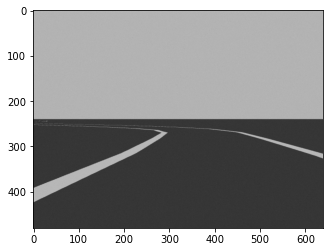

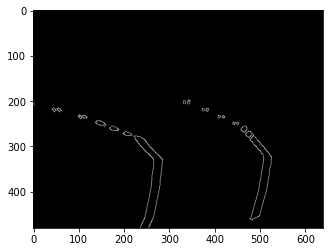

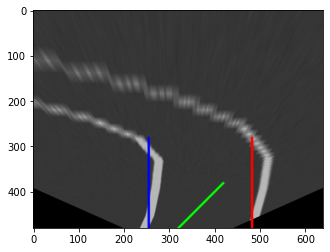

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import math

cv_image = cv2.imread('test3.png') #Straight

edge_img, transform_only_img = prepareImage(cv_image)

left_points_sorted, right_points_sorted = findLanes(edge_img)

error, transform_only_img = calcPositionError(left_points_sorted, right_points_sorted, transform_only_img)

    
    
plt.figure()
plt.imshow(cv_image)
plt.figure()
plt.imshow(edge_img,'gray')
plt.figure()
plt.imshow(transform_only_img)

In [ ]:
import numpy as np
import cv2
import math
from simple_pid import PID
import matplotlib.pyplot as plt

pid = PID(0.5, 0.01, 0.005, setpoint = 0)
pid.output_limits = (-0.5,0.5)

        
def prepareImage(img):
    '''
    Bird's eye view perspective transform followed by Canny Edge Detection.
    Return both the edge+transformed image and the target lane centre
    '''
    perspective_mat = cv2.getPerspectiveTransform(
    np.array([[0,354],[288,251],[352,251],[640,354]], dtype="float32"), 
    np.array([[200,480],[200,0],[440,0],[440,480]], dtype="float32"))
    transformed_only_img = cv2.warpPerspective(img  , perspective_mat, (640,480))
    img = cv2.cvtColor(transformed_only_img.copy(), cv2.COLOR_BGR2GRAY)
    (thresh, img) = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
    img = cv2.blur(img ,(5,5))
    img  = cv2.Canny(img , int(max(0,0.7*np.median(img ))), int(min(255,1.3*np.median(img ))))
    lane_centre = img.shape[1]/2
    return img, transformed_only_img, lane_centre

def findLanes(img):
    '''
    Hough transfrom followed by sorting of detected lines to find right and left lanes.
    Returns x coordinates from left and right lane respectivley sorted by the corresponding y coordinate in ascending order.
    '''
    _lines = cv2.HoughLinesP(
    img,
    rho=10,
    theta=np.pi / 60,
    threshold=0,
    lines=np.array([]),
    minLineLength=10,
    maxLineGap=15
    )
    lines = []
    if _lines is not None:
        for i in range(len(_lines)):
            lines.append(_lines[i][0])
    lines = np.array(lines)

    left_lines = []
    right_lines = []
    lines_sorted = np.array(sorted(lines, key=lambda x: x[1]))
    left_bound = np.max(lines_sorted[:10,0])
    right_bound = np.min(lines_sorted[:10,0])
    for line in lines_sorted:
        if len(left_lines) == 0 and len(right_lines) == 0:
            if abs(line[0]-left_bound) < abs(line[0]-right_bound):
                left_lines.append(line)
            else:
                right_lines.append(line)
        elif len(left_lines) == 0:
            if abs(line[0]-left_bound) < abs(line[0]-right_lines[-1][0]):
                left_lines.append(line)
            else:
                right_lines.append(line)
        elif len(right_lines) == 0:
            if abs(line[0]-left_lines[-1][0]) < abs(line[0]-right_bound):
                left_lines.append(line)
            else:
                right_lines.append(line)
        else:
            if abs(line[0]-left_lines[-1][0]) < abs(line[0]-right_lines[-1][0]):
                left_lines.append(line)
            else:
                right_lines.append(line)
                
    left_points_x = []
    left_points_y = []
    right_points_x = []
    right_points_y = []
    for i in left_lines:
        left_points_x.extend([i[0], i[2]])
        left_points_y.extend([i[1], i[3]])
    for i in right_lines:
        right_points_x.extend([i[0], i[2]])
        right_points_y.extend([i[1], i[3]])
    
    return poly_left, poly_right

def calcPositionError(left_points_sorted, right_points_sorted, lane_centre):
    '''
    Calculates normalized error between two detected lanes and centre to feed to a PID controller.
    '''
    if len(left_points_sorted) > 0 and len(right_points_sorted) > 0:
        x_left = left_points_sorted[-1][0]
        x_right = right_points_sorted[-1][0]
        avg_x = (x_left + x_right) / 2
        error = (avg_x - lane_centre) / lane_centre
    else:
        print("No lanes detected")
        error = 0
    return error

def showLanes(poly_left, poly_right, img):
    max_y = img.shape[0]
    y = np.linspace(0, max_y)
    
    start_centre = img.shape[1] / 2
    start_left = np.polyval(poly_left, max_y)
    start_right = np.polyval(poly_right, max_y)
    avg_start = (start_left+start_right)/2
    start_error = (avg_start - start_centre) / start_centre
    

    left_line = np.array(list(zip(np.polyval(poly_left, y),y)), np.int32)
    right_line = np.array(list(zip(np.polyval(poly_right, y),y)), np.int32)

    img = cv2.polylines(img,[left_line], False, [255,0,0], 5)
    img = cv2.polylines(img,[right_line], False, [0,0,255], 5)
    img = cv2.line(img, (int(avg_start), 0), (int(avg_start), max_y), (0,255,0), 5, cv2.LINE_AA)
    
    
    
    return img, error



#cv_image = self.bridge.imgmsg_to_cv2(ros_msg,desired_encoding='bgr8')

cv_image = cv2.imread('test2.png') #Straight

processed_img, transformed_img, lane_centre = prepareImage(cv_image)

poly_left, poly_right = findLanes(processed_img)

extrap_img, error = showLanes(poly_left, poly_right, transformed_img)

control = pid(error)

print(error)
print(control)


plt.figure()
plt.imshow(cv_image)
plt.figure()
plt.imshow(processed_img,'gray')
plt.figure()
plt.imshow(extrap_img,'gray')
            

In [9]:
import numpy as np
import cv2
import math
from simple_pid import PID
import matplotlib.pyplot as plt

pid = PID(0.5, 0.01, 0.005, setpoint = 0)
pid.output_limits = (-0.5,0.5)

        
def prepareImage(img):
    '''
    Bird's eye view perspective transform followed by Canny Edge Detection.
    Return both the edge+transformed image and the target lane centre
    '''
    perspective_mat = cv2.getPerspectiveTransform(
    np.array([[0,354],[288,251],[352,251],[640,354]], dtype="float32"), 
    np.array([[200,480],[200,0],[440,0],[440,480]], dtype="float32"))
    transformed_only_img = cv2.warpPerspective(img  , perspective_mat, (640,480))
    img = cv2.cvtColor(transformed_only_img.copy(), cv2.COLOR_BGR2GRAY)
    (thresh, img) = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
    img = cv2.blur(img ,(5,5))
    img  = cv2.Canny(img , int(max(0,0.7*np.median(img ))), int(min(255,1.3*np.median(img ))))
    return img, transformed_only_img

def findLanes(img):
    '''
    Hough transfrom followed by sorting of detected lines to find right and left lanes.
    Returns x coordinates from left and right lane respectivley sorted by the corresponding y coordinate in ascending order.
    '''
    _lines = cv2.HoughLinesP(
    img,
    rho=10,
    theta=np.pi / 180,
    threshold=0,
    lines=np.array([]),
    minLineLength=0,
    maxLineGap=0
    )
    lines = []
    if _lines is not None:
        for i in range(len(_lines)):
            lines.append(_lines[i][0])
    lines = np.array(lines)

    left_lines = []
    right_lines = []
    lines_sorted = np.array(sorted(lines, key=lambda x: x[1]))
    left_bound = np.max(lines_sorted[:10,0])
    right_bound = np.min(lines_sorted[:10,0])
    for line in lines_sorted:
        if len(left_lines) == 0 and len(right_lines) == 0:
            if abs(line[0]-left_bound) < abs(line[0]-right_bound):
                left_lines.append(line)
            else:
                right_lines.append(line)
        elif len(left_lines) == 0:
            if abs(line[0]-left_bound) < abs(line[0]-right_lines[-1][0]):
                left_lines.append(line)
            else:
                right_lines.append(line)
        elif len(right_lines) == 0:
            if abs(line[0]-left_lines[-1][0]) < abs(line[0]-right_bound):
                left_lines.append(line)
            else:
                right_lines.append(line)
        else:
            if abs(line[0]-left_lines[-1][0]) < abs(line[0]-right_lines[-1][0]):
                left_lines.append(line)
            else:
                right_lines.append(line)
                
    left_points_x = []
    left_points_y = []
    right_points_x = []
    right_points_y = []
    for i in left_lines:
        if i[3] > 220:
            left_points_x.extend([i[0], i[2]])
            left_points_y.extend([i[1], i[3]])
    for i in right_lines:
        if i[3] > 220:
            right_points_x.extend([i[0], i[2]])
            right_points_y.extend([i[1], i[3]])
    
    return left_points_x, right_points_x

def calcPositionError(left_points_sorted, right_points_sorted, img):
    '''
    Calculates normalized error between two detected lanes and centre to feed to a PID controller.
    '''
    if len(left_points_sorted) > 0 and len(right_points_sorted) > 0:
        lane_centre = img.shape[1]/2
        x_left = left_points_sorted[-1][0]
        x_right = right_points_sorted[-1][0]
        avg_x = (x_left + x_right) / 2
        error = (avg_x - lane_centre) / lane_centre
        img = cv2.line(img, (int(avg_x), 300), (int(avg_x), img.shape[0]), (0,255,0), 5, cv2.LINE_AA)
        img = cv2.line(img, (int(x_left), 300), (int(x_left), img.shape[0]), (255,0,0), 5, cv2.LINE_AA)
        img = cv2.line(img, (int(x_right), 300), (int(x_right), img.shape[0]), (0,0,255), 5, cv2.LINE_AA)
    else:
        print("No lanes detected")
        error = 0
    return error, img



#cv_image = self.bridge.imgmsg_to_cv2(ros_msg,desired_encoding='bgr8')

cv_image = cv2.imread('test1.png') #Straight

processed_img, transformed_img = prepareImage(cv_image)

x_left, x_right = findLanes(processed_img)

extrap_img, error = calcPositionError(x_left, x_right, transformed_img)

control = pid(error)

print(error)
print(control)


plt.figure()
plt.imshow(cv_image)
plt.figure()
plt.imshow(processed_img,'gray')
plt.figure()
plt.imshow(extrap_img,'gray')
            

IndexError: invalid index to scalar variable.

In [ ]:
import numpy as np
import cv2
import math
from simple_pid import PID
import matplotlib.pyplot as plt

def calc_line_fits(img):
    '''
    Uses a sliding window of the image to calculate lane centres by taking the peak values of a histogram
    '''
    nwindows = 15
    margin = 60
    minpix = 30

    # Take a histogram of the bottom half of the image
    histogram = np.sum(img[int(img.shape[0]//1.2):,:], axis=0)

    #plt.figure()
    #plt.plot(histogram)
    
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((img, img, img))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    averagex_base = int((leftx_base - rightx_base) / 2)

    # Set height of windows
    window_height = np.int(img.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2)
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2)
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 3)
    right_fit = np.polyfit(righty, rightx, 3)

    return left_fit, right_fit, averagex_base

def prepareImage(img):
    '''
    Bird's eye view perspective transform followed by thresholding and blurring
    Return both the edge+transformed image and the target lane centre
    '''
    perspective_mat = cv2.getPerspectiveTransform(
    np.array([[0,354],[288,251],[352,251],[640,354]], dtype="float32"), 
    np.array([[200,480],[200,0],[440,0],[440,480]], dtype="float32"))
    transformed_only_img = cv2.warpPerspective(img  , perspective_mat, (640,480))
    img = cv2.cvtColor(transformed_only_img.copy(), cv2.COLOR_BGR2GRAY)
    (thresh, img) = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
    img = cv2.blur(img ,(5,5))
    return img, transformed_only_img

def showLanes(poly_left, poly_right, img, x_vel, y_vel):
    '''
    Shows the polynomial fitted lanes on the orignal birds eye view transformed image
    '''
    max_y = img.shape[0]
    y = np.linspace(200, max_y)
    
    start_centre = img.shape[1] / 2


    left_line = np.array(list(zip(np.polyval(poly_left, y),y)), np.int32)
    right_line = np.array(list(zip(np.polyval(poly_right, y),y)), np.int32)

    img = cv2.polylines(img,[left_line], False, [255,0,0], 5)
    img = cv2.polylines(img,[right_line], False, [0,0,255], 5)
    img = cv2.line(img, (int(img.shape[1]/2 -  x_vel * 200), int(max_y - y_vel * 200)), (int(img.shape[1]/2), max_y), (0,255,0), 5, cv2.LINE_AA)
   
    return img

cv_image = cv2.imread('test2.png') #Straight

processed_img, transformed_img = prepareImage(cv_image)

x_vel = .2
y_vel = .2

left_fit, right_fit, averagex_base = calc_line_fits(processed_img)

extrap_img = showLanes(left_fit, right_fit, transformed_img, x_vel, y_vel)

plt.figure()
plt.imshow(cv_image)
plt.figure()
plt.imshow(extrap_img)


In [ ]:
import numpy as np
import cv2
from cv_bridge import CvBridge
import rclpy
from rclpy.node import Node
import math
from simple_pid import PID

from sensor_msgs.msg import Image
from std_msgs.msg import Float32
from geometry_msgs.msg import Twist

pid = PID(0.5, 0.01, 0.005, setpoint = 320)
pid.output_limits = (-0.5,0.5)

class FollowTrack(Node):
    def __init__(self):
        super().__init__('follow_track')

        self.bridge = CvBridge()

        self.sub = self.create_subscription(Image, '/camera/image_raw', self.callback, 5)
        
        self.pub = self.create_publisher(Twist, 'cmd_vel', 1)
        
    def prepareImage(self, img):
        '''
        Bird's eye view perspective transform followed by thresholding and blurring
        Return both the edge+transformed image and the target lane centre
        '''
        perspective_mat = cv2.getPerspectiveTransform(
        np.array([[0,354],[288,251],[352,251],[640,354]], dtype="float32"), 
        np.array([[200,480],[200,0],[440,0],[440,480]], dtype="float32"))
        transformed_only_img = cv2.warpPerspective(img  , perspective_mat, (640,480))
        img = cv2.cvtColor(transformed_only_img.copy(), cv2.COLOR_BGR2GRAY)
        (thresh, img) = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
        img = cv2.blur(img ,(5,5))
        return img, transformed_only_img

    def findLanes(self, img):
        '''
        Uses a sliding window of the image to calculate lane centres by taking the peak values of a histogram
        '''
        nwindows = 15
        margin = 60
        minpix = 30

        # Take a histogram of the bottom half of the image
        histogram = np.sum(img[int(img.shape[0]//1.2):,:], axis=0)

        #plt.figure()
        #plt.plot(histogram)

        # Create an output image to draw on and  visualize the result
        out_img = np.dstack((img, img, img))*255
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]/2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint
        averagex_base = int((leftx_base - rightx_base) / 2)

        # Set height of windows
        window_height = np.int(img.shape[0]/nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = img.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = img.shape[0] - (window+1)*window_height
            win_y_high = img.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2)
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2)
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds]
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]

        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 3)
        right_fit = np.polyfit(righty, rightx, 3)

        return left_fit, right_fit, averagex_base
    
    
    def showLanes(self, poly_left, poly_right, img, x_vel, y_vel):
        '''
        Shows the polynomial fitted lanes on the orignal birds eye view transformed image
        '''
        max_y = img.shape[0]
        y = np.linspace(0, max_y)
        left_line = np.array(list(zip(np.polyval(poly_left, y),y)), np.int32)
        right_line = np.array(list(zip(np.polyval(poly_right, y),y)), np.int32)
        img = cv2.polylines(img,[left_line], False, [255,0,0], 10)
        img = cv2.polylines(img,[right_line], False, [0,0,255], 10)
        img = cv2.line(img, (int(img.shape[1]/2 -  x_vel * 200), int(max_y - y_vel * 200)), (int(img.shape[1]/2), max_y), (0,255,0), 5, cv2.LINE_AA)
        return img

    def callback(self, ros_msg):
        cv_image = self.bridge.imgmsg_to_cv2(ros_msg,desired_encoding='bgr8')

        processed_img, transformed_img = self.prepareImage(cv_image)


        left_fit, right_fit, averagex_base = self.calc_line_fits(processed_img)
        
        velocity = Twist()
        velocity.linear.x = 0.2
        velocity.angular.z = pid(error)

        self.pub.publish(velocity)

        extrap_img = self.showLanes(left_fit, right_fit, transformed_img, velocity.angular.z, velocity.linear.x)
        
        
        cv2.imshow("Lanes Detected Image", extrap_img)
        cv2.waitKey(2)

            

def main(args=None):
    rclpy.init(args=args)

    follow_track = FollowTrack()

    print("Starting up lane following node")
    rclpy.spin(follow_track)

if __name__ == '__main__':
    main()

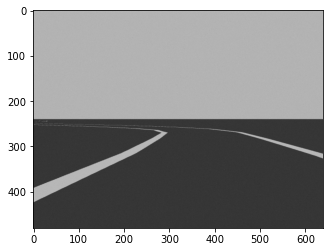

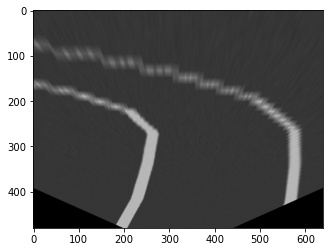

In [27]:
   
    
cv_image = cv2.imread('test3.png') #Straight
h, w, _ = cv_image.shape
c = int(w/2)
hz = h-229


perspective_mat = cv2.getPerspectiveTransform(
np.array([[0,h-66],[c-32,hz],[c+32,hz],[w,h-66]], dtype="float32"), 
np.array([[200,480],[200,0],[440,0],[440,480]], dtype="float32"))
extrap_img = cv2.warpPerspective(cv_image  , perspective_mat, (640,480))

plt.figure()
plt.imshow(cv_image)
plt.figure()
plt.imshow(extrap_img)

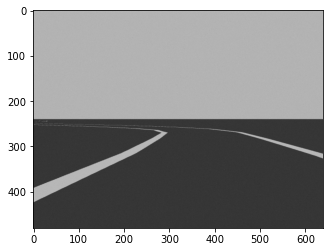

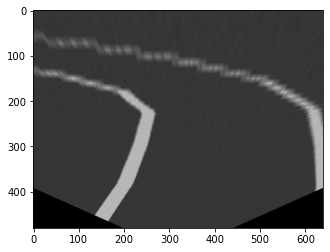

In [33]:
   
    
cv_image = cv2.imread('test3.png') #Straight
h, w, _ = cv_image.shape
c = int(w/2)
hz = h-229

perspective_mat = cv2.getPerspectiveTransform(
np.array([[0,480],[288,251],[352,251],[640,480]], dtype="float32"), 
np.array([[200,480],[200,0],[440,0],[440,480]], dtype="float32"))
extrap_img = cv2.warpPerspective(cv_image  , perspective_mat, (640,480))

plt.figure()
plt.imshow(cv_image)
plt.figure()
plt.imshow(extrap_img)